In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils import get_root_dir
from matplotlib import dates as mdates
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


### This Notebook will be used to test models for time-series forecasting on crime data

In [2]:
df_crime = pd.read_csv(os.path.join(get_root_dir(), 'data/processed/final.csv'))
df_crime.head()

,Major,Minor,Borough,Date,Count,Population,Count_Per_1000
0,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-04-01,6.0,182838,0.032816
1,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-05-01,5.0,182838,0.027347
2,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-06-01,11.0,182838,0.060163
3,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-07-01,10.0,182838,0.054693
4,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-08-01,6.0,182838,0.032816


In [3]:
total_crime_trend = df_crime.groupby('Date').sum(numeric_only=True)['Count_Per_1000']
total_crime_trend

Date
2010-04-01    268.322545
2010-05-01    274.519513
2010-06-01    277.427047
2010-07-01    281.972314
2010-08-01    261.862011
                 ...    
2023-07-01    273.811522
2023-08-01    262.543980
2023-09-01    263.757539
2023-10-01    280.749514
2023-11-01    271.461315
Name: Count_Per_1000, Length: 164, dtype: float64

<Axes: xlabel='Date'>

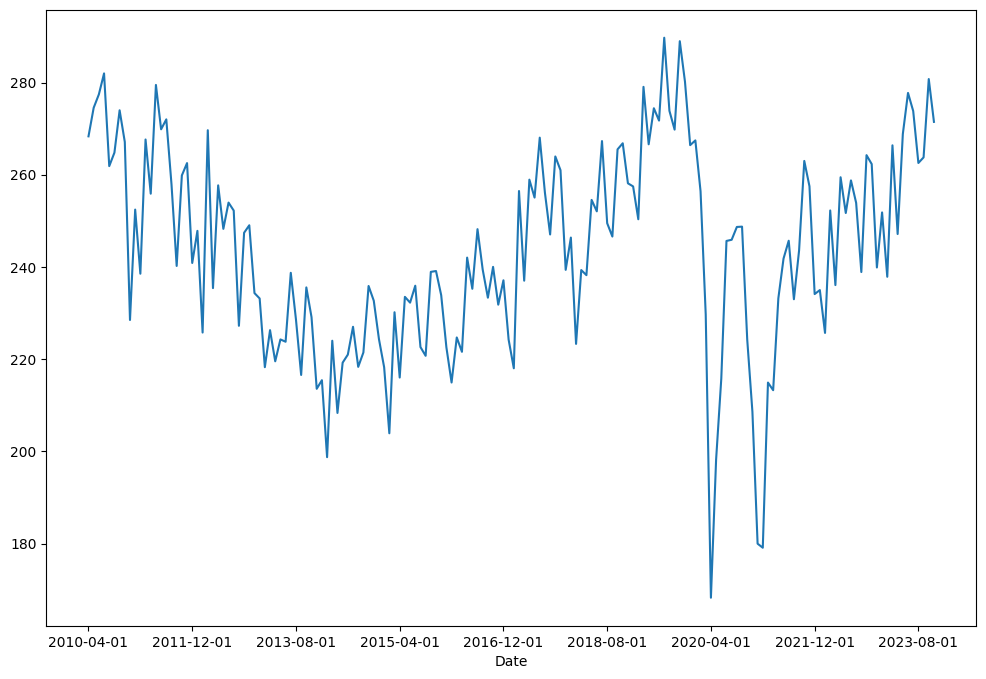

In [4]:
total_crime_trend.plot(figsize=(12,8))

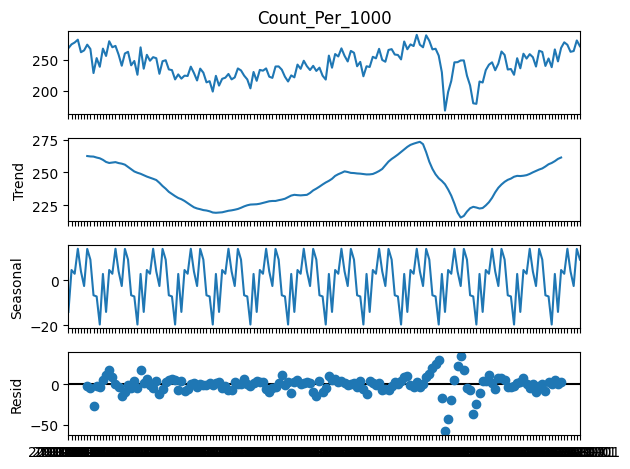

In [6]:
seasonal_decomp = seasonal_decompose(x=total_crime_trend, model="additive", period=12)
seasonal_decomp.plot();

In [43]:
df_train = total_crime_trend.iloc[:-12]
df_test = total_crime_trend.iloc[-12:]

total_crime_trend.shape, df_train.shape, df_test.shape

((164,), (152,), (12,))

<Axes: xlabel='Date'>

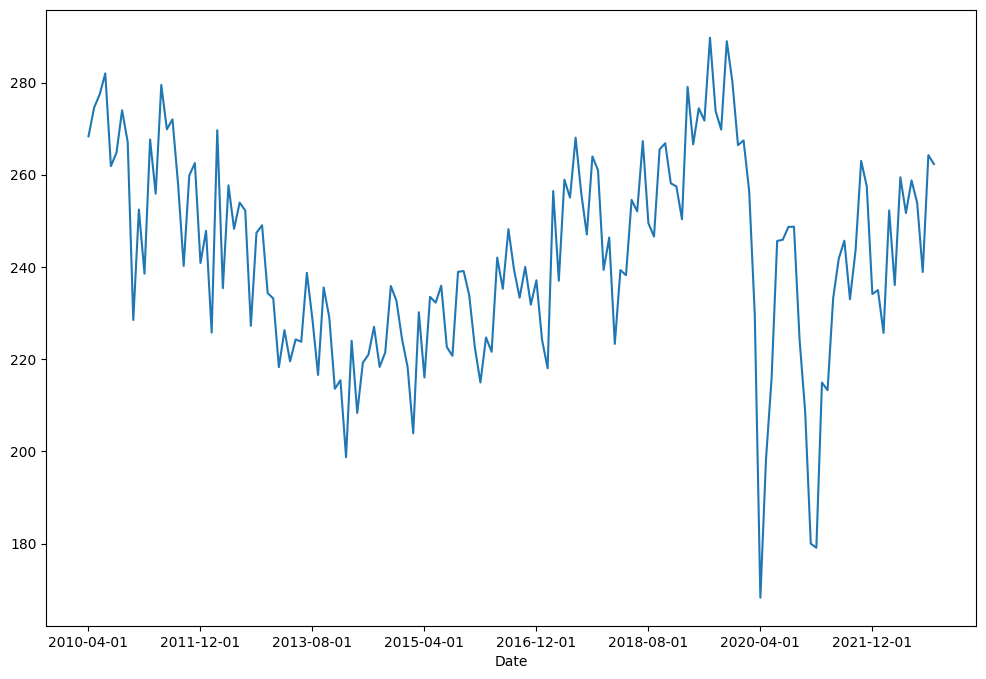

In [44]:
df_train.plot(figsize=(12, 8))

In [9]:
s_dec_additive = seasonal_decompose(x=df_train, model="additive", period=12)
s_dec_multiplicative = seasonal_decompose(x=df_train, model="multiplicative", period=12)

In [10]:
observed = s_dec_additive.observed
trend = s_dec_additive.trend
seasonal = s_dec_additive.seasonal
residual = s_dec_additive.resid

df_additive = pd.DataFrame({"observed":observed, "trend":trend, "seasonal":seasonal,"residual":residual})

In [11]:
observed = s_dec_multiplicative.observed
trend = s_dec_multiplicative.trend
seasonal = s_dec_multiplicative.seasonal
residual = s_dec_multiplicative.resid

df_multiplicative = pd.DataFrame({"observed":observed, "trend":trend, "seasonal":seasonal,"residual":residual})

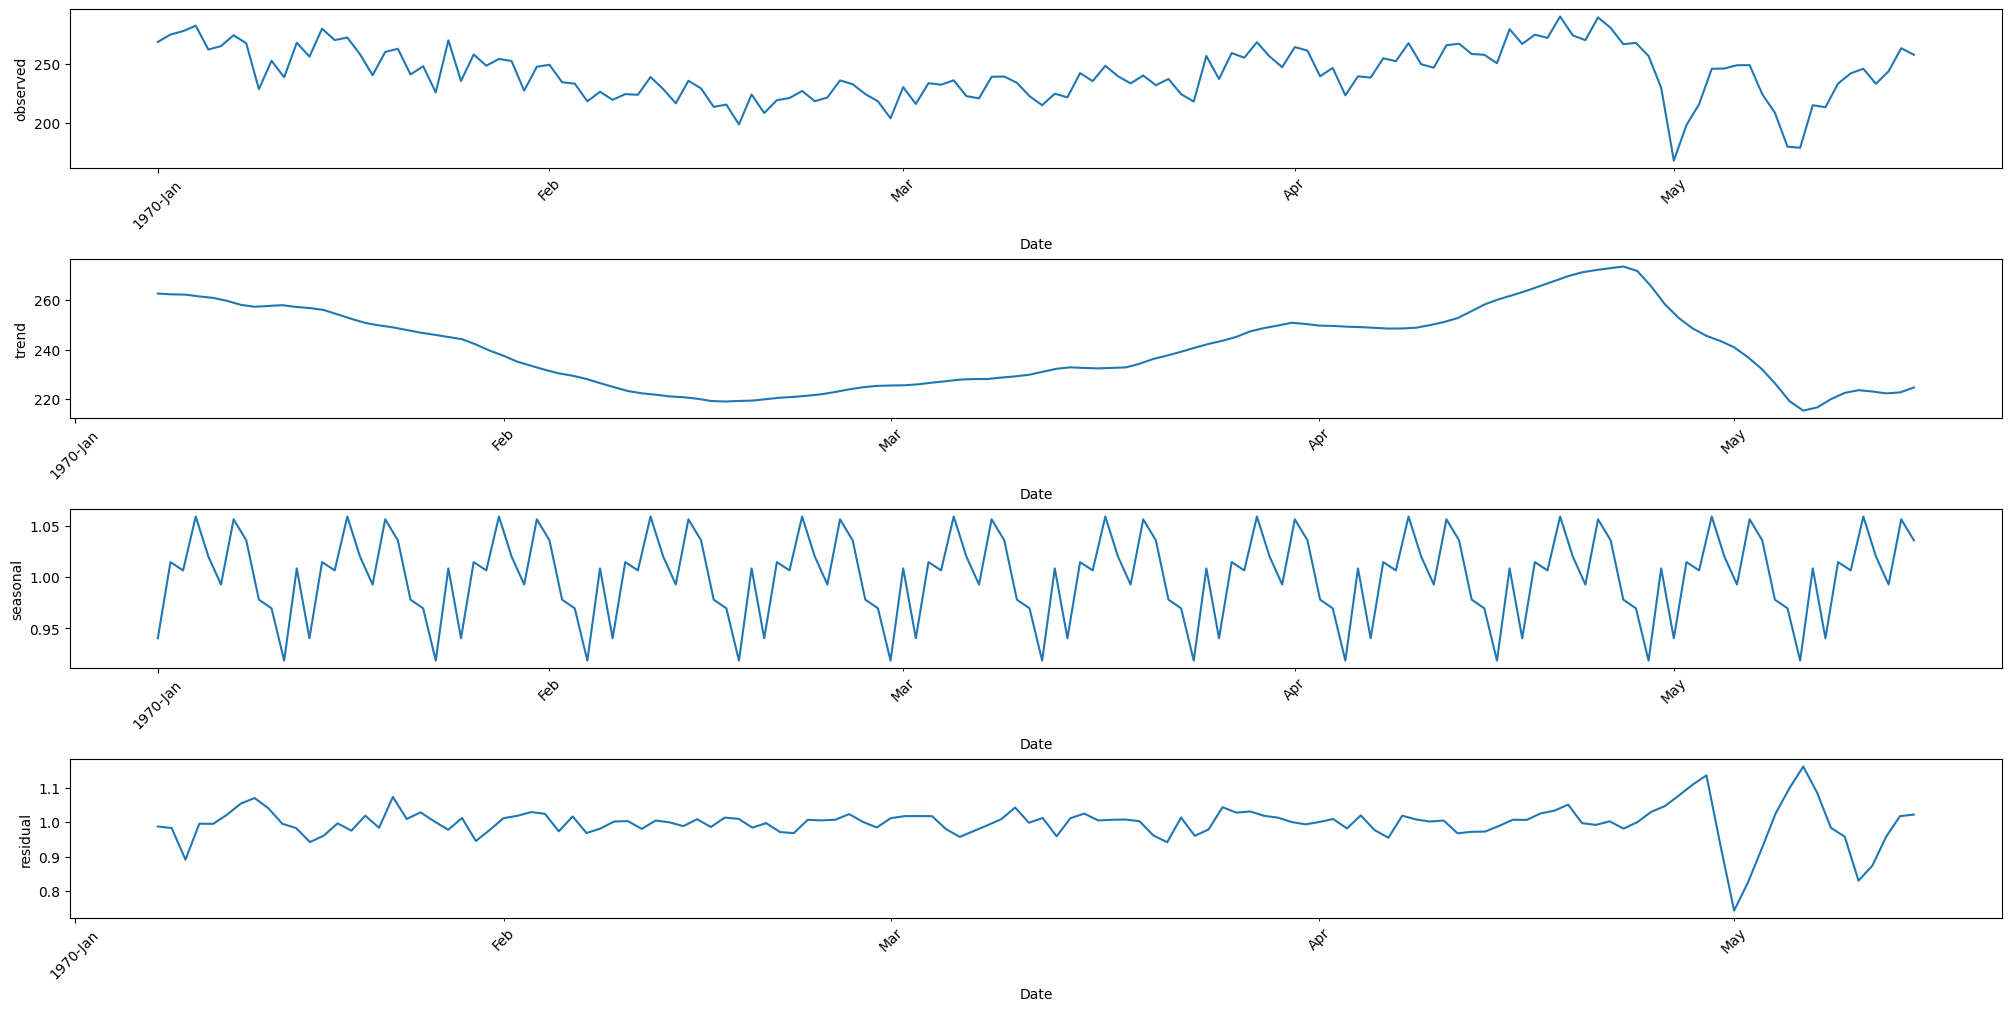

In [12]:
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10), constrained_layout=True)
for i, ax in enumerate(axes):
    ax = df_multiplicative.iloc[:,i].plot(ax=ax)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(df_multiplicative.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

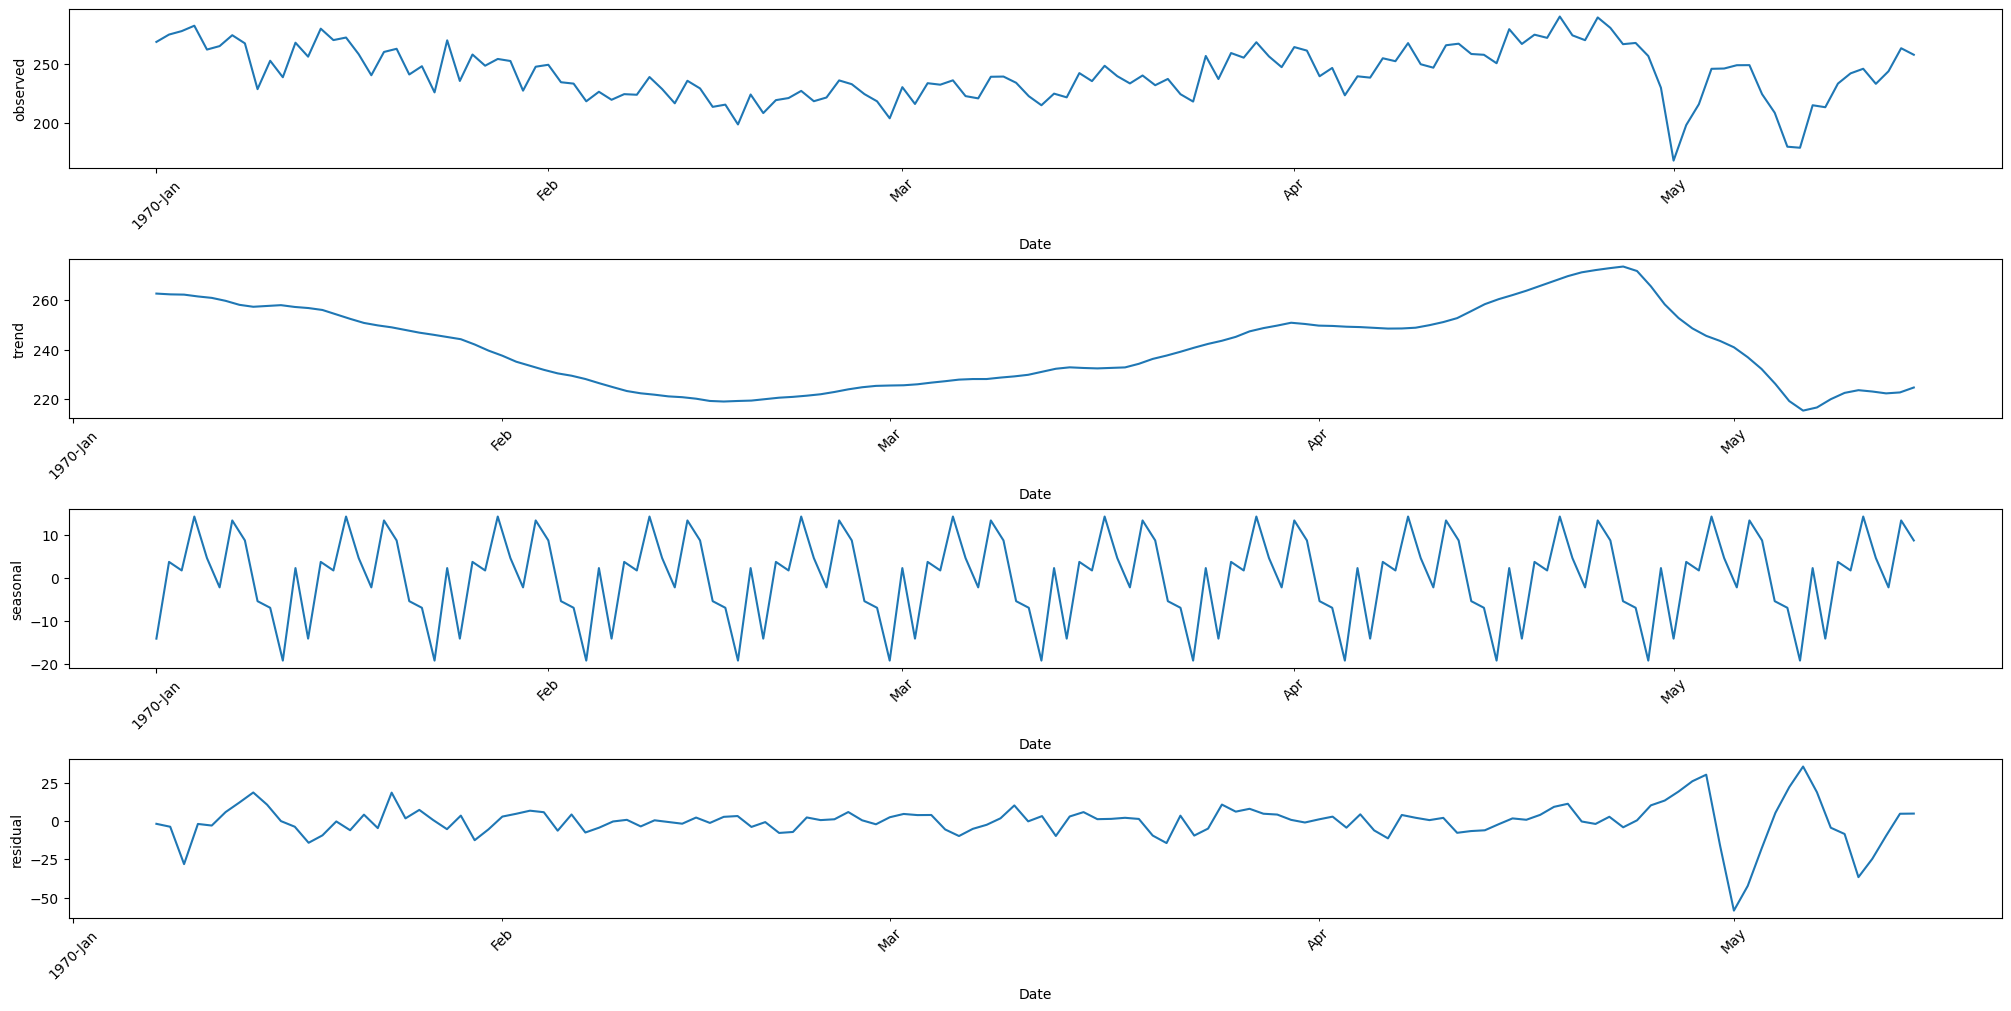

In [13]:
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10), constrained_layout=True)
for i, ax in enumerate(axes):
    ax = df_additive.iloc[:,i].plot(ax=ax)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(df_additive.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

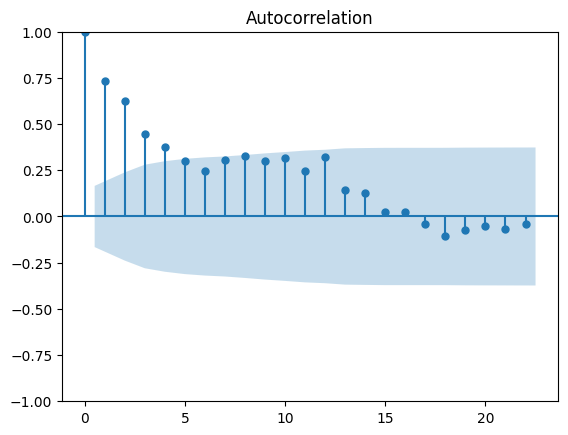

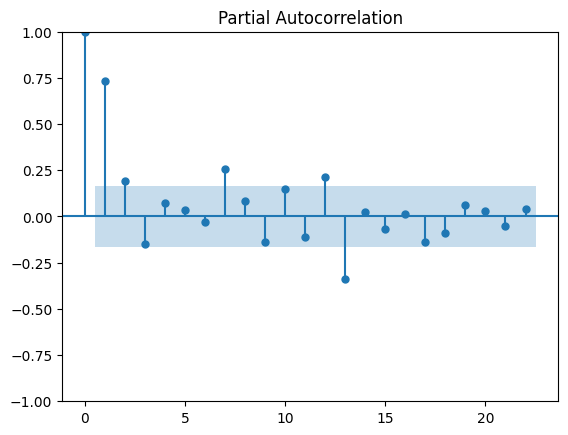

In [14]:
acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## ADF test for stationarity

In [15]:
adf_test = adfuller(df_train)
print(f'p-value : {adf_test[1]}')

p-value : 0.13274823750533477


In [16]:
adf_test = adfuller(residual.dropna())
print(f'p-value : {adf_test[1]}')

p-value : 1.325071955941097e-13


## Transforming data to stationary

0.0037405855519805475


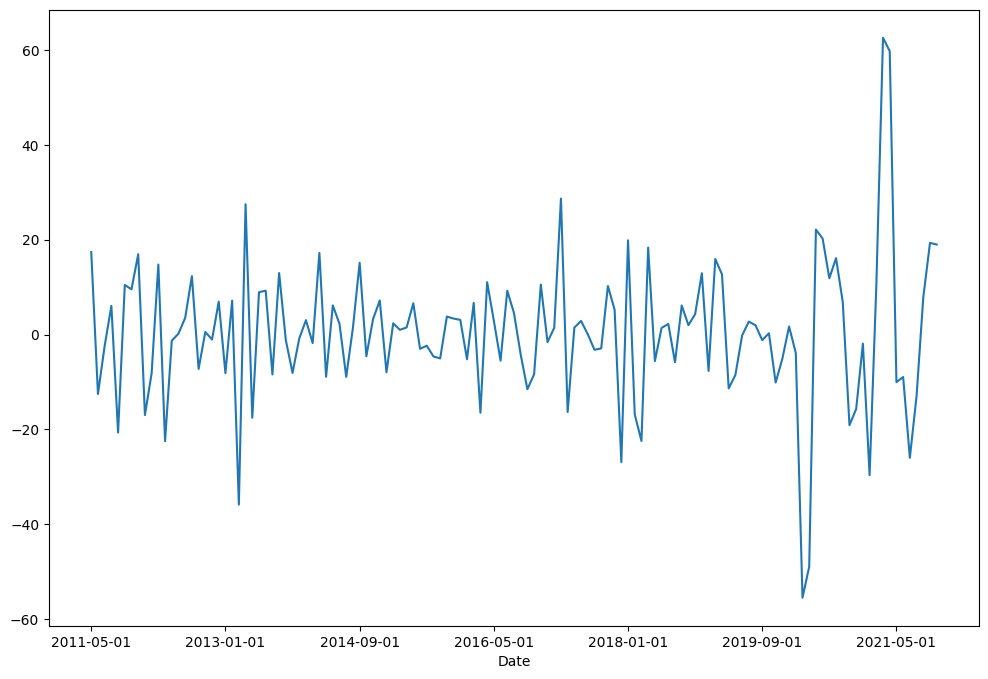

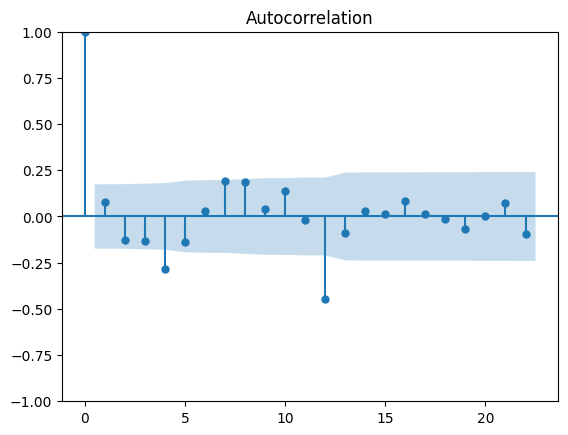

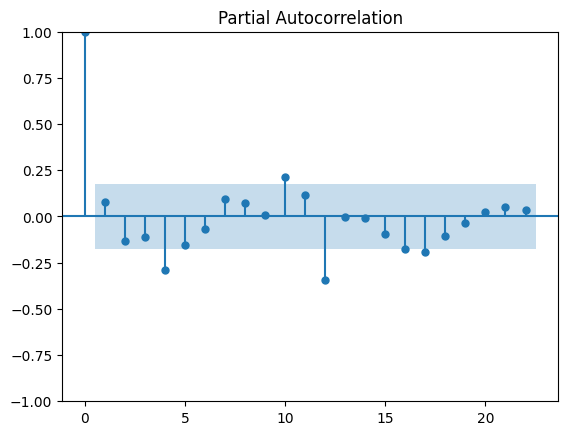

In [17]:
df_train_diff = df_train.diff(12).diff(1).dropna()

print(adfuller(df_train_diff)[1])

df_train_diff.plot(figsize=(12,8))

acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

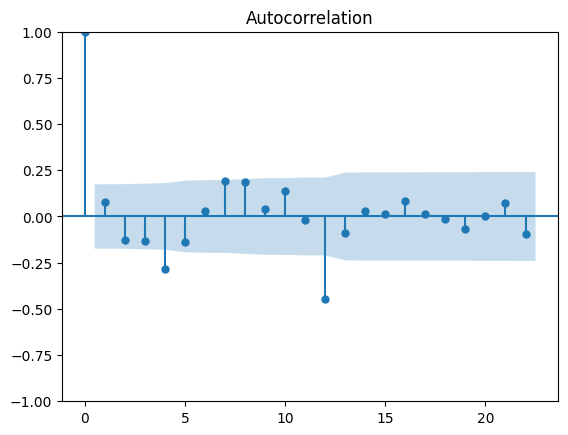

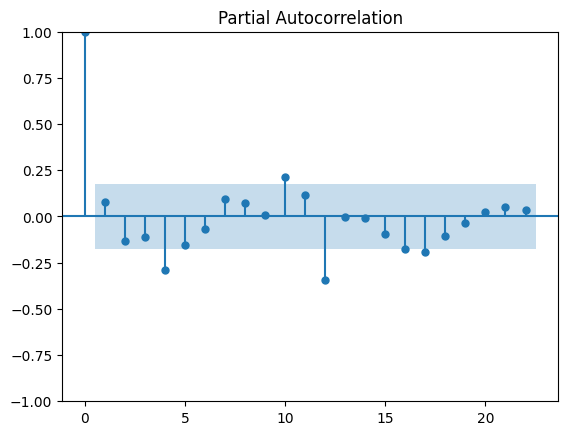

In [18]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

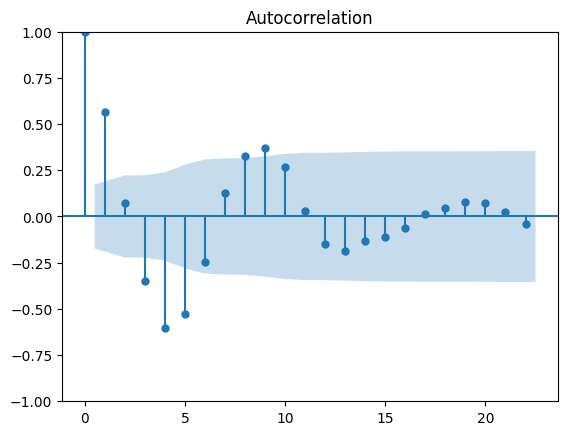

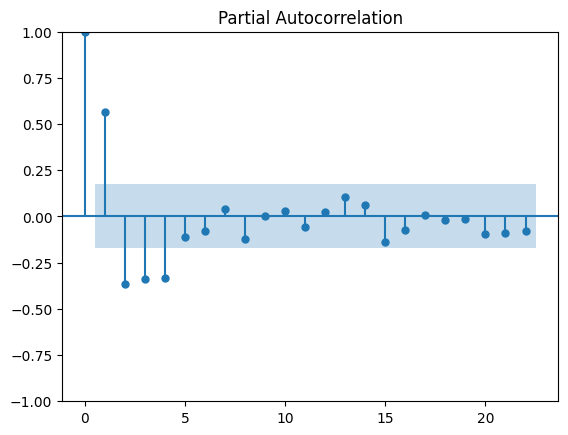

In [19]:
acf_diff = plot_acf(residual.dropna())

pacf_diff = plot_pacf(residual.dropna())

## Fit ARIMA Model

In [25]:
model = ARIMA(residual, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  140
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 202.110
Date:                Wed, 17 Apr 2024   AIC                           -398.221
Time:                        19:26:30   BIC                           -389.418
Sample:                    04-01-2010   HQIC                          -394.643
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0754      0.049      1.537      0.124      -0.021       0.171
ar.L2         -0.0866      0.063     -1.365      0.172      -0.211       0.038
sigma2         0.0021      0.000     12.465      0.0

/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Check Model Residuals

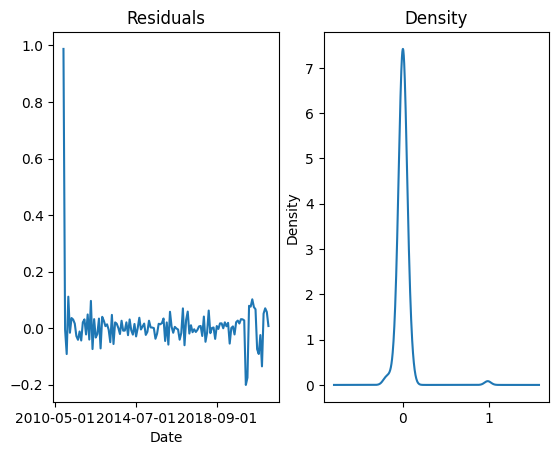

In [26]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

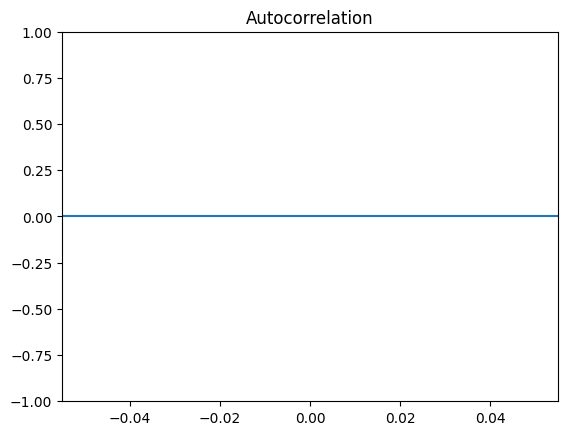

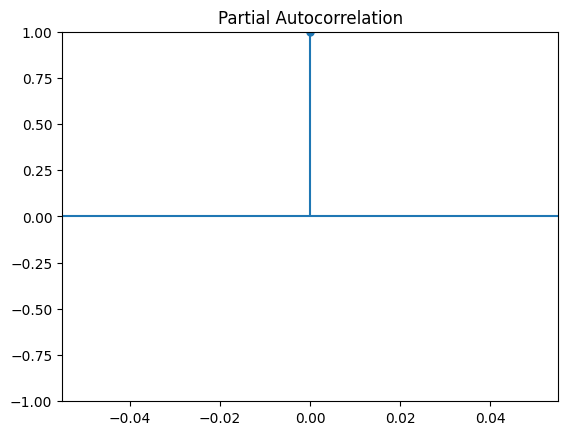

In [27]:
acf_resid = plot_acf(residuals)

pacf_resid = plot_pacf(residuals)

## Forecasting with fitted model

In [28]:
df = pd.DataFrame(total_crime_trend)


<Axes: xlabel='Date'>

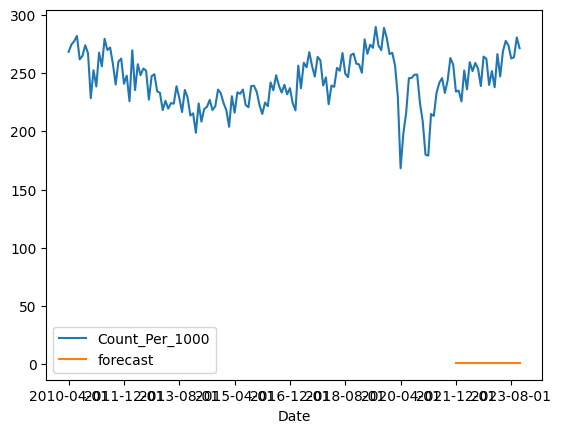

In [29]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast'] = [None]*len(df_train) + list(forecast_test)

df.plot()

In [30]:
forecast_test

2021-12-01    1.017484
2022-01-01    1.017485
2022-02-01    1.017485
2022-03-01    1.017485
2022-04-01    1.017485
2022-05-01    1.017485
2022-06-01    1.017485
2022-07-01    1.017485
2022-08-01    1.017485
2022-09-01    1.017485
2022-10-01    1.017485
2022-11-01    1.017485
2022-12-01    1.017485
2023-01-01    1.017485
2023-02-01    1.017485
2023-03-01    1.017485
2023-04-01    1.017485
2023-05-01    1.017485
2023-06-01    1.017485
2023-07-01    1.017485
2023-08-01    1.017485
2023-09-01    1.017485
2023-10-01    1.017485
2023-11-01    1.017485
Freq: MS, Name: predicted_mean, dtype: float64

## Auto Arima on Residuals

In [36]:
df_train

Date
2010-04-01    268.322545
2010-05-01    274.519513
2010-06-01    277.427047
2010-07-01    281.972314
2010-08-01    261.862011
                 ...    
2021-07-01    245.683911
2021-08-01    232.990208
2021-09-01    243.587278
2021-10-01    262.986265
2021-11-01    257.490465
Name: Count_Per_1000, Length: 140, dtype: float64

In [45]:
model = pm.auto_arima(df_train, 
                      m=12,                 # frequency of series                      
                      seasonal=True,        # TRUE if seasonal series
                      d=None,               # let model determine 'd'
                      test='adf',           # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12,   # maximum p and q
                      D=None,               # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1274.443, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1225.730, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1241.060, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1272.444, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1259.040, Time=0.20 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1209.077, Time=0.67 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1207.530, Time=0.23 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1225.388, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1209.052, Time=0.32 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=1210.962, Time=0.52 sec
 ARIMA(0,1,0)(2,0,0)[12]             : 

In [46]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  152
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -599.765
Date:                            Wed, 17 Apr 2024   AIC                           1205.530
Time:                                    19:30:35   BIC                           1214.582
Sample:                                04-01-2010   HQIC                          1209.208
                                     - 11-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3592      0.052      6.948      0.000       0.258       0.461
ar.S.L24       0.3882      0.068   

<Axes: >

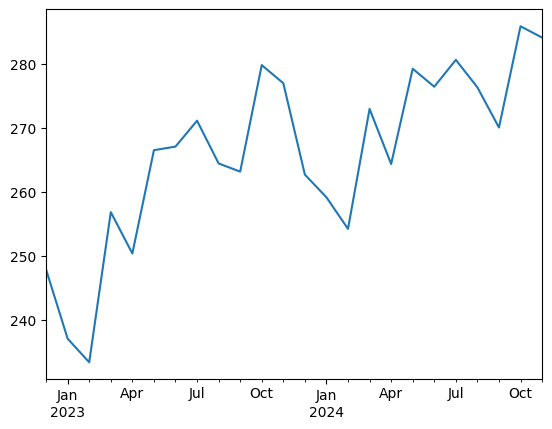

In [47]:
forecast_test = model.predict(n_periods=24)

# df['forecast'] = [None]*len(df_train) + list(forecast_test)

# df['2020-01-01':].plot()

forecast_test.plot()

<Axes: xlabel='Date'>

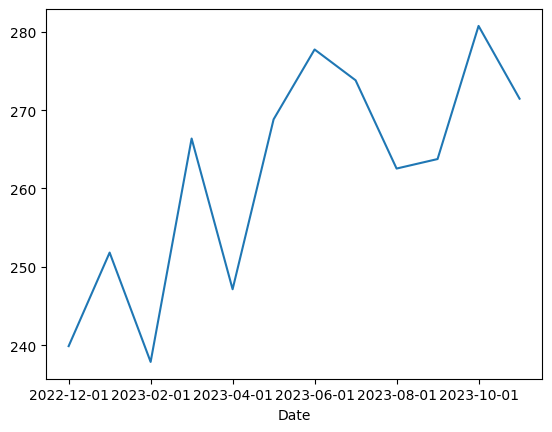

In [48]:

df_test.plot()

## Full Auto Arima

In [ ]:
model = pm.auto_arima(df_train,
                      start_p=0, start_q=0,
                      max_p=12, max_q=12,
                      test='adf',
                      seasonal=True,
                      m=12,
                      d=None,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

In [ ]:
forecast_test, conf_int = model.predict(n_periods=60, return_conf_int=True)
forecast_test.plot()